In [ ]:
from sklearn.preprocessing import MinMaxScaler
same_seeds(1) 

params = {
    'num_epoch' : 350,
    'batch_size' : 60,
    'lr' : 4.8e-4,
    'weight_decay' : 0.00000,
    'sigma' : 5.0,
    'MMD_lambda' : 2e-4,
    'model_name' : 'FWAE',
} # for FWAE training
all = pd.read_excel('data.xlsx', header=0).iloc[:,0:25].to_numpy()
print(all.shape)
raw_x = all[:,0:7]
raw_descriptors = all[:,7:24]
raw_y = all[:, 24].reshape(-1,1)

scaler = MinMaxScaler()
raw_descriptors = scaler.fit_transform(raw_descriptors)



dataset = FeatureDataset(raw_x[:], raw_y[:], raw_descriptors[:]) 
dataloader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True) 
print(raw_x[0:10],raw_y[0:10],raw_descriptors[0:5])
print(raw_x.shape[1])


(154, 25)
[[0.5     0.      0.      0.5     0.      0.      0.     ]
 [0.5     0.      0.      0.495   0.005   0.      0.     ]
 [0.5     0.      0.      0.495   0.      0.005   0.     ]
 [0.5     0.      0.      0.4925  0.0075  0.      0.     ]
 [0.5     0.      0.      0.49    0.      0.      0.01   ]
 [0.5     0.      0.      0.489   0.011   0.      0.     ]
 [0.5     0.      0.      0.48875 0.01125 0.      0.     ]
 [0.5     0.      0.      0.485   0.      0.015   0.     ]
 [0.5     0.      0.      0.485   0.      0.      0.015  ]
 [0.5     0.      0.      0.48    0.      0.02    0.     ]] [[190.]
 [273.]
 [250.]
 [317.]
 [361.]
 [343.]
 [334.]
 [400.]
 [272.]
 [409.]] [[1.         1.         1.         1.         1.         1.
  0.81989924 1.         1.         1.         0.         0.59252971
  0.88568927 0.78653066 0.69204448 1.         0.        ]
 [0.978129   0.97808471 0.98075069 0.96953478 0.97966388 0.98171239
  0.8057876  0.97871831 1.         0.97857568 0.008371   0.61035

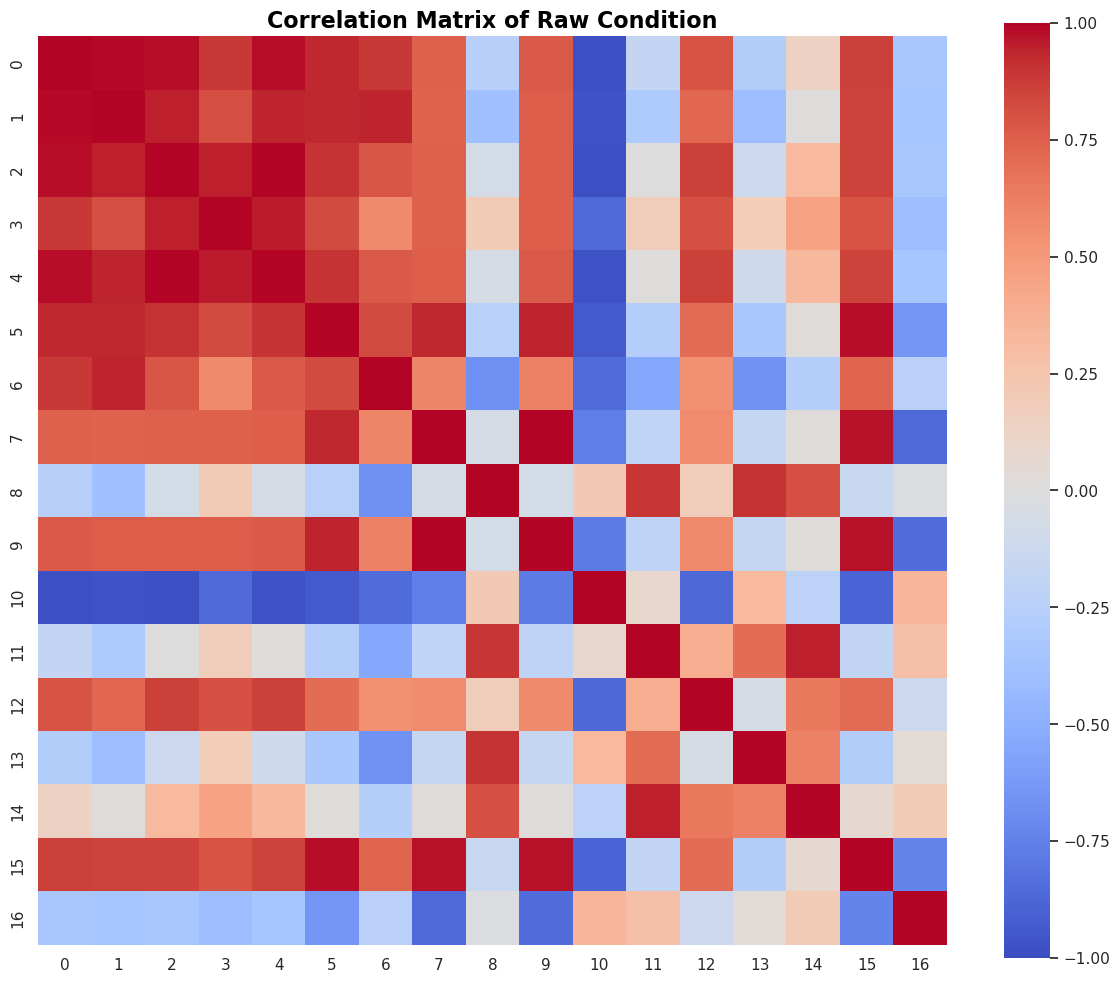

皮尔逊相关系数矩阵已保存为 Pearson_correlation_coefficient.xlsx

特征分组（相关性 >= 0.9）：
组 1: 10, 1, 6, 2, 0, 7, 4, 5, 9, 3, 15
组 2: 13, 8
组 3: 14, 11

单独的特征（没有与其他特征相关性 >= 0.9）：
12, 16

特征分组已保存为 Feature_Groups.xlsx


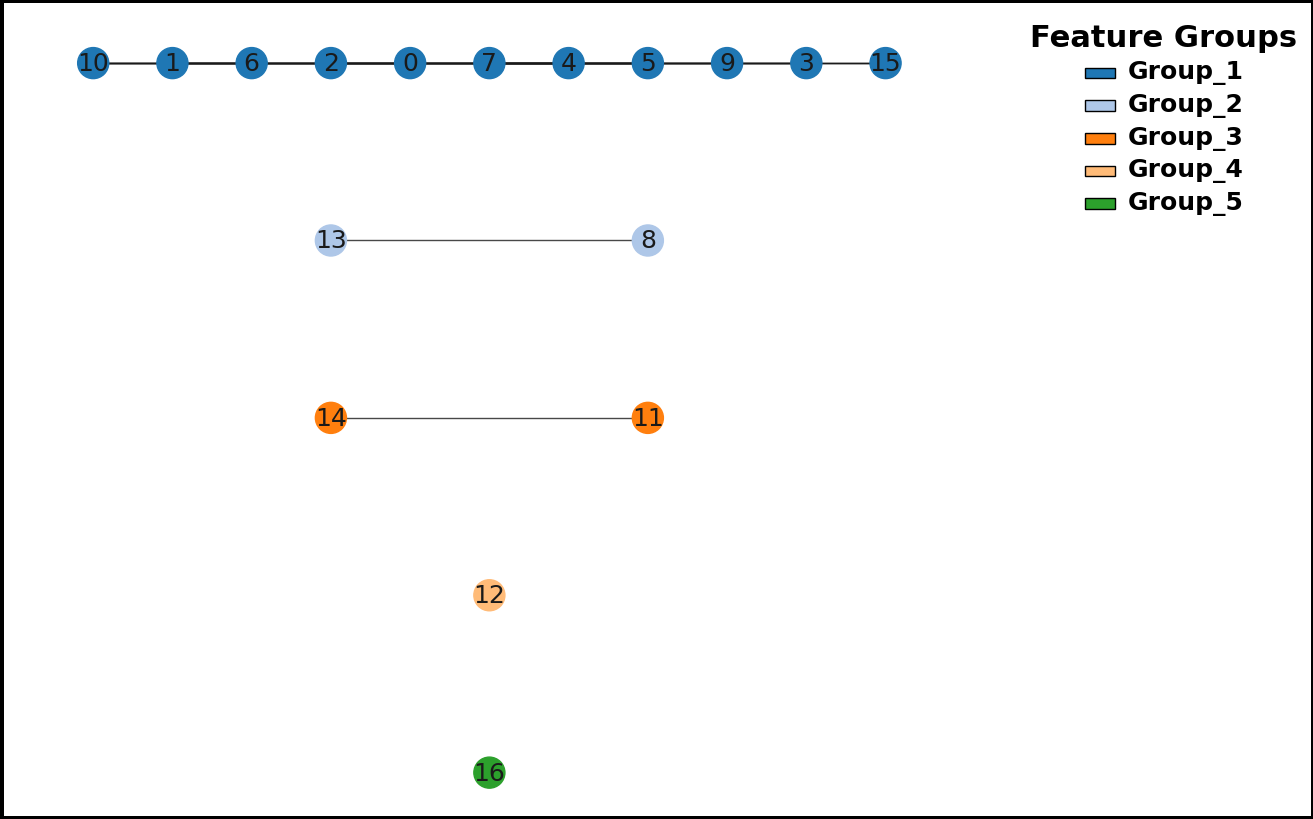

特征分组可视化已保存为 Feature_Groups_Visualization_Hierarchical.tiff


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx  
from matplotlib.patches import Patch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import MinMaxScaler
import math


raw_descriptors_df = pd.DataFrame(raw_descriptors)

correlation_matrix = raw_descriptors_df.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Correlation Matrix of Raw Condition', fontsize=16, fontweight='bold', color='black')
plt.tight_layout()
plt.show()


correlation_matrix.to_excel('Pearson_correlation_coefficient.xlsx', index=True)
print("皮尔逊相关系数矩阵已保存为 Pearson_correlation_coefficient.xlsx")


threshold = 0.9

G = nx.Graph()

features = correlation_matrix.columns.astype(str)
G.add_nodes_from(features)

for i in range(len(features)):
    for j in range(i+1, len(features)):
        feature_i = features[i]
        feature_j = features[j]
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) >= threshold:
            G.add_edge(feature_i, feature_j)


connected_components = list(nx.connected_components(G))

feature_groups = [list(component) for component in connected_components if len(component) > 1]


grouped_features = set([feature for group in feature_groups for feature in group])
single_features = [feature for feature in features if feature not in grouped_features]


print("\n特征分组（相关性 >= 0.9）：")
for idx, group in enumerate(feature_groups, 1):
    
    group_str = ', '.join([str(feature) for feature in group])
    print(f"组 {idx}: {group_str}")

if single_features:
    single_features_str = ', '.join([str(feature) for feature in single_features])
    print("\n单独的特征（没有与其他特征相关性 >= 0.9）：")
    print(single_features_str)

group_data = {
    'Group': [],
    'Features': []
}

for idx, group in enumerate(feature_groups, 1):
    group_data['Group'].append(f'Group_{idx}')
    group_data['Features'].append(', '.join([str(feature) for feature in group]))

for idx, feature in enumerate(single_features, len(feature_groups) + 1):
    group_data['Group'].append(f'Group_{idx}')
    group_data['Features'].append(str(feature))

group_df = pd.DataFrame(group_data)


group_df.to_excel('Feature_Groups.xlsx', index=False)
print("\n特征分组已保存为 Feature_Groups.xlsx")

feature_to_group = {}
for idx, group in enumerate(feature_groups, 1):
    for feature in group:
        feature_to_group[feature] = f'Group_{idx}'
for idx, feature in enumerate(single_features, len(feature_groups) + 1):
    feature_to_group[feature] = f'Group_{idx}'

num_groups = len(group_data['Group'])
palette = sns.color_palette('tab20', num_groups)
group_colors = {group: palette[idx] for idx, group in enumerate(group_data['Group'])}

node_colors = [group_colors[feature_to_group[feature]] for feature in G.nodes()]

layer_spacing = 3  
group_centers = {}
for idx, group in enumerate(group_data['Group'], 1):
    group_centers[group] = (0, -layer_spacing * idx)  

node_positions = {}
max_group_size = max(group_df['Features'].apply(lambda x: len(x.split(', '))))  

for group in group_data['Group']:
    center_x, center_y = group_centers[group]
    members = group_df[group_df['Group'] == group]['Features'].values[0].split(', ')
    num_members = len(members)
    if num_members == 1:
        
        node_positions[members[0]] = (center_x, center_y)
    else:
        
        total_width = 8  
        spacing = total_width / (num_members + 1)
        for i, member in enumerate(members, 1):
            x = center_x - total_width / 2 + spacing * i
            y = center_y
            node_positions[member] = (x, y)


pos = node_positions  

legend_elements = [Patch(facecolor=group_colors[f'Group_{i+1}'], edgecolor='black', label=f'Group_{i+1}') 
                   for i in range(num_groups)]

plt.figure(figsize=(14, 9))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=1)
nx.draw_networkx_edges(G, pos, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=18, font_family='sans-serif')

legend = plt.legend(handles=legend_elements, title='Feature Groups', 
                    bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.setp(legend.get_title(), fontsize=22, fontweight='bold', color='black')
for text in legend.get_texts():
    text.set_fontsize(18)
    text.set_fontweight('bold')
    text.set_color('black')

plt.axis('off')

fig = plt.gcf()

fig.patch.set_edgecolor('black')      
fig.patch.set_linewidth(5)            
fig.patch.set_facecolor('white')      

plt.tight_layout(pad=3)

plt.savefig('Feature_Groups_Visualization_Hierarchical.tiff', 
            format='tiff', dpi=600, 
            facecolor=fig.get_facecolor(), 
            edgecolor=fig.get_edgecolor(),
            bbox_inches='tight')

plt.show()

print("特征分组可视化已保存为 Feature_Groups_Visualization_Hierarchical.tiff")


In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import itertools

feature_groups = {
    "Group 1": [5, 9, 15, 10, 4, 6, 7, 1, 2, 3, 0],
    "Group 2": [13, 8],
    "Group 3": [11, 14],
    "Group 4": [12],
    "Group 5": [16]
}


np.random.seed(1)
X = all[:, 7:24]
y = all[:, 24].reshape(-1, 1)

kf = KFold(n_splits=5, shuffle=True, random_state=1)  

def calculate_cv_rmse(X, y, selected_features):
    if len(selected_features) == 0:
        return np.inf
    temp_X = X[:, selected_features]
    rmses = []
    for train_index, test_index in kf.split(temp_X):
        X_train, X_test = temp_X[train_index], temp_X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=500, random_state=1)
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    return np.mean(rmses)

def generate_valid_combinations(feature_groups, max_features):
    group_names = list(feature_groups.keys())
    group_features = [feature_groups[group] for group in group_names]

    valid_combinations = []
    for num_features in range(0, max_features + 1):  
        for feature_combination in combinations(range(len(group_names)), num_features):
            if feature_combination: 
                feature_lists = [group_features[group_idx] for group_idx in feature_combination]
                for selected_features in itertools.product(*feature_lists):
                    valid_combinations.append(selected_features)
            else:
                valid_combinations.append(())
    return valid_combinations

valid_combinations = generate_valid_combinations(feature_groups, max_features=5)

results = []

for combination in valid_combinations:
    combination_indices = list(combination)  
    rmse = calculate_cv_rmse(X, y, combination_indices)
    results.append({
        "Combination": combination,
        "RMSE": rmse
    })
    print(f"Combination: {combination}, RMSE: {rmse}")

results_df = pd.DataFrame(results)

output_file = "Feature_Combinations_RMSE.xlsx"
results_df.to_excel(output_file, index=False)
print(f"Results saved to {output_file}")


Combination: (), RMSE: inf


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5,), RMSE: 222.31438213242555


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9,), RMSE: 200.97325156084565


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15,), RMSE: 258.13208107644874


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10,), RMSE: 276.14200344305266


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4,), RMSE: 225.22447996539003


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6,), RMSE: 224.02080705965795


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7,), RMSE: 186.52887324936168


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1,), RMSE: 219.05608952417788


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2,), RMSE: 221.30866977022183


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3,), RMSE: 172.1120747315347


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (0,), RMSE: 205.8067038379774
Combination: (13,), RMSE: 133.91997744197275


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (8,), RMSE: 261.2111952821234


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (11,), RMSE: 181.6447149674974


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (14,), RMSE: 269.891627303232
Combination: (12,), RMSE: 133.5890195320088


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (16,), RMSE: 276.70304138783797
Combination: (5, 13), RMSE: 133.92555707985227


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5, 8), RMSE: 185.90457021442057
Combination: (9, 13), RMSE: 133.92694793484975


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9, 8), RMSE: 174.49053153965042
Combination: (15, 13), RMSE: 133.92635514570568


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15, 8), RMSE: 204.1896796066165
Combination: (10, 13), RMSE: 133.92751437628846


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10, 8), RMSE: 233.1095618445169
Combination: (4, 13), RMSE: 133.92357795834332


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4, 8), RMSE: 188.35784668774312
Combination: (6, 13), RMSE: 133.92588758741448


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6, 8), RMSE: 188.97760422802054
Combination: (7, 13), RMSE: 133.92252496149803


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 8), RMSE: 170.78337213543483
Combination: (1, 13), RMSE: 133.9260549901042


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1, 8), RMSE: 184.46084610922426
Combination: (2, 13), RMSE: 133.92294240813774


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2, 8), RMSE: 191.1296604984164
Combination: (3, 13), RMSE: 133.9259116063413


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3, 8), RMSE: 150.8319444272243
Combination: (0, 13), RMSE: 133.92605310614948


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (0, 8), RMSE: 185.32749248146595


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5, 11), RMSE: 136.01080408398315


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5, 14), RMSE: 193.01695030507514


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9, 11), RMSE: 132.49064160746815


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9, 14), RMSE: 171.4768572241855


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15, 11), RMSE: 143.91918212546915


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15, 14), RMSE: 221.46302859135994


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10, 11), RMSE: 166.0547722465828


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10, 14), RMSE: 214.59213166877117


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4, 11), RMSE: 137.09120777424187


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4, 14), RMSE: 196.34990858849943


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6, 11), RMSE: 136.7792826989084


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6, 14), RMSE: 195.17747089941565


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (7, 11), RMSE: 131.36068956284265


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 14), RMSE: 166.50455488802726


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1, 11), RMSE: 137.47782324092339


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1, 14), RMSE: 190.84770186252845


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2, 11), RMSE: 137.6189827318497


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2, 14), RMSE: 197.0827836514454


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3, 11), RMSE: 133.24247461948704


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3, 14), RMSE: 157.08699019637226


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (0, 11), RMSE: 135.2779525827299


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (0, 14), RMSE: 175.62642817839327
Combination: (5, 12), RMSE: 133.66032099372347
Combination: (9, 12), RMSE: 133.66226642753577
Combination: (15, 12), RMSE: 133.66006338641915
Combination: (10, 12), RMSE: 133.65957801255712
Combination: (4, 12), RMSE: 133.65926131408358
Combination: (6, 12), RMSE: 133.6601826592439
Combination: (7, 12), RMSE: 133.66288702402406
Combination: (1, 12), RMSE: 133.6596168767569
Combination: (2, 12), RMSE: 133.65939814480512
Combination: (3, 12), RMSE: 133.65741529290926
Combination: (0, 12), RMSE: 133.65946512366247


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5, 16), RMSE: 212.2837112105175


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9, 16), RMSE: 177.61340154916022


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15, 16), RMSE: 197.0393316156172


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10, 16), RMSE: 229.10072800501544


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4, 16), RMSE: 216.32764933561126


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6, 16), RMSE: 215.51708836170025


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 16), RMSE: 169.48741838170454


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1, 16), RMSE: 204.76568202349753


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2, 16), RMSE: 217.77864054560365


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3, 16), RMSE: 159.95491978790565


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (0, 16), RMSE: 193.66768740868844
Combination: (13, 11), RMSE: 133.92333048301754
Combination: (13, 14), RMSE: 133.9401827856414


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (8, 11), RMSE: 144.85167404906977


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (8, 14), RMSE: 221.94845231917225
Combination: (13, 12), RMSE: 133.14794821261404
Combination: (8, 12), RMSE: 133.6580150281593
Combination: (13, 16), RMSE: 133.92182726870044


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (8, 16), RMSE: 198.72523242808518
Combination: (11, 12), RMSE: 133.65738160643951
Combination: (14, 12), RMSE: 133.65957101119974


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (11, 16), RMSE: 169.65711865500492


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (14, 16), RMSE: 213.93985294916652
Combination: (12, 16), RMSE: 133.35072640699076
Combination: (5, 13, 11), RMSE: 133.92587004429947
Combination: (5, 13, 14), RMSE: 133.92987120176852


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5, 8, 11), RMSE: 137.58742907861728


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (5, 8, 14), RMSE: 156.06178124974807
Combination: (9, 13, 11), RMSE: 133.90182968881626
Combination: (9, 13, 14), RMSE: 133.93278092149114


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9, 8, 11), RMSE: 135.11447511111578


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (9, 8, 14), RMSE: 137.50386428114854
Combination: (15, 13, 11), RMSE: 133.924099853933
Combination: (15, 13, 14), RMSE: 133.93141942380194


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15, 8, 11), RMSE: 135.39834491053662


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (15, 8, 14), RMSE: 174.58525279389033
Combination: (10, 13, 11), RMSE: 133.90488062845074
Combination: (10, 13, 14), RMSE: 133.9238465737341


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10, 8, 11), RMSE: 136.169188075268


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (10, 8, 14), RMSE: 165.79732727093503
Combination: (4, 13, 11), RMSE: 133.92347321576239
Combination: (4, 13, 14), RMSE: 133.92744529770422


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4, 8, 11), RMSE: 136.96400474212822


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (4, 8, 14), RMSE: 158.62784946825508
Combination: (6, 13, 11), RMSE: 133.9241696932667
Combination: (6, 13, 14), RMSE: 133.92969365995955


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6, 8, 11), RMSE: 136.68263565402893


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (6, 8, 14), RMSE: 158.01905067466996
Combination: (7, 13, 11), RMSE: 133.90605639596612
Combination: (7, 13, 14), RMSE: 133.9322337069394


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 8, 11), RMSE: 131.96920017894283


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (7, 8, 14), RMSE: 134.55212677219214
Combination: (1, 13, 11), RMSE: 133.92584583961627
Combination: (1, 13, 14), RMSE: 133.92815927894537


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1, 8, 11), RMSE: 136.20473315502895


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (1, 8, 14), RMSE: 155.23096864090377
Combination: (2, 13, 11), RMSE: 133.9235490441078
Combination: (2, 13, 14), RMSE: 133.92709741854668


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2, 8, 11), RMSE: 137.1369039801346


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (2, 8, 14), RMSE: 159.6953312547946
Combination: (3, 13, 11), RMSE: 133.94036477307162
Combination: (3, 13, 14), RMSE: 133.9254606975427


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3, 8, 11), RMSE: 133.80703678891172


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (3, 8, 14), RMSE: 137.3678671285374
Combination: (0, 13, 11), RMSE: 133.92247676915642
Combination: (0, 13, 14), RMSE: 133.92763299725485


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (0, 8, 11), RMSE: 136.23481742193624


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (0, 8, 14), RMSE: 166.9676841652148
Combination: (5, 13, 12), RMSE: 138.8521687927681
Combination: (5, 8, 12), RMSE: 138.47797233852734
Combination: (9, 13, 12), RMSE: 138.84985073240983
Combination: (9, 8, 12), RMSE: 138.4519141400404
Combination: (15, 13, 12), RMSE: 138.85135947781362
Combination: (15, 8, 12), RMSE: 138.49552503608484
Combination: (10, 13, 12), RMSE: 138.85116477648063
Combination: (10, 8, 12), RMSE: 138.50535347300084
Combination: (4, 13, 12), RMSE: 138.850127114076
Combination: (4, 8, 12), RMSE: 138.48020670727416
Combination: (6, 13, 12), RMSE: 138.8512613551856
Combination: (6, 8, 12), RMSE: 138.48229148639697
Combination: (7, 13, 12), RMSE: 138.84864835513514
Combination: (7, 8, 12), RMSE: 138.44353071914333
Combination: (1, 13, 12), RMSE: 138.85175186422558
Combination: (1, 8, 12), RMSE: 138.47406080895203
Combination: (2, 13, 12), RMSE: 138.8503946717527
Combination: (2, 8, 12), RMSE: 138.48004646573156
Combination: (3, 13, 12), RMSE: 138.83502191

/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5, 8, 16), RMSE: 174.2800116132457
Combination: (9, 13, 16), RMSE: 133.91296865084672


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9, 8, 16), RMSE: 150.63644666663828
Combination: (15, 13, 16), RMSE: 133.93286038281758


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15, 8, 16), RMSE: 192.38806151106206
Combination: (10, 13, 16), RMSE: 133.95315434625266


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10, 8, 16), RMSE: 187.14102320972694
Combination: (4, 13, 16), RMSE: 133.92838036604664


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4, 8, 16), RMSE: 171.18965499771753
Combination: (6, 13, 16), RMSE: 133.9318077826335


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6, 8, 16), RMSE: 170.64045352064284
Combination: (7, 13, 16), RMSE: 133.93585814863133


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 8, 16), RMSE: 147.3467297661472
Combination: (1, 13, 16), RMSE: 133.92996490064522


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1, 8, 16), RMSE: 198.4167345224766
Combination: (2, 13, 16), RMSE: 133.9291637383713


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2, 8, 16), RMSE: 167.73947567442238
Combination: (3, 13, 16), RMSE: 133.9275606380511


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3, 8, 16), RMSE: 138.66675124120604
Combination: (0, 13, 16), RMSE: 133.92845891085148


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (0, 8, 16), RMSE: 162.33260165334417
Combination: (5, 11, 12), RMSE: 138.50422304268483
Combination: (5, 14, 12), RMSE: 138.47757672185264
Combination: (9, 11, 12), RMSE: 138.47835603189384
Combination: (9, 14, 12), RMSE: 138.44990676440563
Combination: (15, 11, 12), RMSE: 138.52073317947097
Combination: (15, 14, 12), RMSE: 138.49316006473197
Combination: (10, 11, 12), RMSE: 138.52929434590342
Combination: (10, 14, 12), RMSE: 138.50439473897075
Combination: (4, 11, 12), RMSE: 138.50879779930872
Combination: (4, 14, 12), RMSE: 138.4755595861911
Combination: (6, 11, 12), RMSE: 138.50741225075558
Combination: (6, 14, 12), RMSE: 138.47587622478096
Combination: (7, 11, 12), RMSE: 138.47069191138775
Combination: (7, 14, 12), RMSE: 138.44102251629016
Combination: (1, 11, 12), RMSE: 138.5029108553612
Combination: (1, 14, 12), RMSE: 138.47107405911873
Combination: (2, 11, 12), RMSE: 138.51109974210084
Combination: (2, 14, 12), RMSE: 138.47787423959988
Combination: (3, 11, 12), RMSE

/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5, 11, 16), RMSE: 136.97026241556165


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5, 14, 16), RMSE: 164.25207224161312


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9, 11, 16), RMSE: 134.82674531239405


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9, 14, 16), RMSE: 140.3505768391999


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15, 11, 16), RMSE: 135.15363858942027


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15, 14, 16), RMSE: 188.33063325052294


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10, 11, 16), RMSE: 137.75339464187908


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10, 14, 16), RMSE: 201.3664171650084


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4, 11, 16), RMSE: 136.0540305467268


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4, 14, 16), RMSE: 170.03579673353644


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6, 11, 16), RMSE: 135.11827127027397


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6, 14, 16), RMSE: 168.0814923162835


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 11, 16), RMSE: 134.0132197710943


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 14, 16), RMSE: 135.70460398431547


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1, 11, 16), RMSE: 136.14298458438006


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1, 14, 16), RMSE: 161.48589067598323


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2, 11, 16), RMSE: 136.22219157144932


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2, 14, 16), RMSE: 170.23027952206672


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3, 11, 16), RMSE: 140.19322366550335


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3, 14, 16), RMSE: 140.21446254567206


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (0, 11, 16), RMSE: 136.27738789096284


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (0, 14, 16), RMSE: 159.3692981907506
Combination: (5, 12, 16), RMSE: 133.92110779964497
Combination: (9, 12, 16), RMSE: 133.92661044311518
Combination: (15, 12, 16), RMSE: 133.92015352036822
Combination: (10, 12, 16), RMSE: 133.91633402459848
Combination: (4, 12, 16), RMSE: 133.9191005999652
Combination: (6, 12, 16), RMSE: 133.92145880389538
Combination: (7, 12, 16), RMSE: 133.92895735911955
Combination: (1, 12, 16), RMSE: 133.91897307724716
Combination: (2, 12, 16), RMSE: 133.91930350251056
Combination: (3, 12, 16), RMSE: 133.91785057122155
Combination: (0, 12, 16), RMSE: 133.91901793291623
Combination: (13, 11, 12), RMSE: 136.43007907483275
Combination: (13, 14, 12), RMSE: 136.42960434029908
Combination: (8, 11, 12), RMSE: 138.5173453339834
Combination: (8, 14, 12), RMSE: 138.49196281891622
Combination: (13, 11, 16), RMSE: 133.88350768493143
Combination: (13, 14, 16), RMSE: 133.94663104064148


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (8, 11, 16), RMSE: 135.7405530424709


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (8, 14, 16), RMSE: 189.08855069384643
Combination: (13, 12, 16), RMSE: 134.33957014949152
Combination: (8, 12, 16), RMSE: 133.9149780317771
Combination: (11, 12, 16), RMSE: 133.9162656785738
Combination: (14, 12, 16), RMSE: 133.9170172037737
Combination: (5, 13, 11, 12), RMSE: 133.4443647841888
Combination: (5, 13, 14, 12), RMSE: 133.44459778449587
Combination: (5, 8, 11, 12), RMSE: 133.12377094067173
Combination: (5, 8, 14, 12), RMSE: 133.11352927507068
Combination: (9, 13, 11, 12), RMSE: 133.4475851117057
Combination: (9, 13, 14, 12), RMSE: 133.44534291609077
Combination: (9, 8, 11, 12), RMSE: 133.1249532908002
Combination: (9, 8, 14, 12), RMSE: 133.1107182900306
Combination: (15, 13, 11, 12), RMSE: 133.44476506703327
Combination: (15, 13, 14, 12), RMSE: 133.447853429
Combination: (15, 8, 11, 12), RMSE: 133.12357584316595
Combination: (15, 8, 14, 12), RMSE: 133.11337619471243
Combination: (10, 13, 11, 12), RMSE: 133.44387182313818
Combination: (10, 13, 14, 12), RMSE: 133

/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (5, 13, 11, 16), RMSE: 133.8935994025312
Combination: (5, 13, 14, 16), RMSE: 133.93200584894484


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (5, 8, 11, 16), RMSE: 146.38908466952063


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (5, 8, 14, 16), RMSE: 179.20159458131295


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (9, 13, 11, 16), RMSE: 133.8894644556783


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (9, 13, 14, 16), RMSE: 133.9321069112412


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (9, 8, 11, 16), RMSE: 140.18989072602


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (9, 8, 14, 16), RMSE: 164.6776298365397
Combination: (15, 13, 11, 16), RMSE: 133.9316368836217
Combination: (15, 13, 14, 16), RMSE: 133.9297342944173


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (15, 8, 11, 16), RMSE: 152.86937389602824


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (15, 8, 14, 16), RMSE: 189.69748181176513
Combination: (10, 13, 11, 16), RMSE: 133.91907828704552
Combination: (10, 13, 14, 16), RMSE: 133.92608557058082


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (10, 8, 11, 16), RMSE: 163.54828778124676


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (10, 8, 14, 16), RMSE: 199.14530783838023
Combination: (4, 13, 11, 16), RMSE: 133.92805574673815
Combination: (4, 13, 14, 16), RMSE: 133.93262067050523


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (4, 8, 11, 16), RMSE: 150.0207694554139


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (4, 8, 14, 16), RMSE: 181.5585915937351


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (6, 13, 11, 16), RMSE: 133.94370069691988
Combination: (6, 13, 14, 16), RMSE: 133.93496077226757


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (6, 8, 11, 16), RMSE: 147.82550456943096


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (6, 8, 14, 16), RMSE: 180.78203887122433


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 13, 11, 16), RMSE: 133.91494798237358


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 13, 14, 16), RMSE: 133.9236531284287


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (7, 8, 11, 16), RMSE: 144.31620481003202


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (7, 8, 14, 16), RMSE: 163.88776097629287


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (1, 13, 11, 16), RMSE: 133.9036807172957
Combination: (1, 13, 14, 16), RMSE: 133.93261029754754


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (1, 8, 11, 16), RMSE: 146.28365460307242


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (1, 8, 14, 16), RMSE: 184.98842778987134
Combination: (2, 13, 11, 16), RMSE: 133.93289004420907
Combination: (2, 13, 14, 16), RMSE: 133.93158572316503


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (2, 8, 11, 16), RMSE: 150.2801559451636


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (2, 8, 14, 16), RMSE: 181.64694259101765
Combination: (3, 13, 11, 16), RMSE: 133.89388337497908
Combination: (3, 13, 14, 16), RMSE: 133.92247503861043


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (3, 8, 11, 16), RMSE: 170.0831583605502


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (3, 8, 14, 16), RMSE: 185.94302823082532
Combination: (0, 13, 11, 16), RMSE: 133.9154574605211
Combination: (0, 13, 14, 16), RMSE: 133.92649565788867


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Combination: (0, 8, 11, 16), RMSE: 189.66264629555752


/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shenghui/anaconda3/envs/shenghui/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Combination: (0, 8, 14, 16), RMSE: 174.54966534727745
Combination: (5, 13, 12, 16), RMSE: 132.85712778835804
Combination: (5, 8, 12, 16), RMSE: 132.92865173333263
Combination: (9, 13, 12, 16), RMSE: 132.85117096329532
Combination: (9, 8, 12, 16), RMSE: 132.91958360490585
Combination: (15, 13, 12, 16), RMSE: 132.86064548304475
Combination: (15, 8, 12, 16), RMSE: 132.92621461348193
Combination: (10, 13, 12, 16), RMSE: 132.85755296748425
Combination: (10, 8, 12, 16), RMSE: 132.92353783172243
Combination: (4, 13, 12, 16), RMSE: 132.85978924642987
Combination: (4, 8, 12, 16), RMSE: 132.92719754391263
Combination: (6, 13, 12, 16), RMSE: 132.8577733330734
Combination: (6, 8, 12, 16), RMSE: 132.92484864014355
Combination: (7, 13, 12, 16), RMSE: 132.85193547649592
Combination: (7, 8, 12, 16), RMSE: 132.91817249837055
Combination: (1, 13, 12, 16), RMSE: 132.85929541276238
Combination: (1, 8, 12, 16), RMSE: 132.92399148473837
Combination: (2, 13, 12, 16), RMSE: 132.85535428274235
Combination: (2,